In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [43]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
C = torch.randn((27, 2))

In [9]:
C[5]

tensor([-1.0414,  0.3905])

In [10]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # should be the same as C[5] but won't use as indexing is equilivant and faster

tensor([-1.0414,  0.3905])

In [11]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [12]:
W1 = torch.randn((6, 100)) # 6 is 3 * 2 (context length * embedding size), 100 is the hidden size which is arbitrary
b1 = torch.randn(100)

In [14]:
# Would love to do something like emb @ W1 + b1 but the shapes don't match
# We need to flatten the embeddings first which we can do through a view
# b1 will be broadcasted to the right shape remember align the dimensions from the right
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # -1 means infer the size from the other dimensions
h # h is the hidden embeddings of the first examples

tensor([[-0.7777,  0.6745, -0.9999,  ...,  0.9945,  0.7787,  0.1078],
        [-0.9826, -0.4545,  0.6746,  ...,  0.9997,  0.9976,  0.8127],
        [-0.9997, -0.8109, -0.8172,  ...,  0.5785,  0.9852, -0.4434],
        ...,
        [-0.9679,  0.5375,  0.9206,  ..., -0.9059, -0.9419, -0.9896],
        [ 0.8851,  0.9949,  0.9983,  ..., -0.9990, -0.9965, -0.9948],
        [ 0.9004,  0.9986, -0.9274,  ..., -0.9803, -0.9999, -0.9919]])

In [15]:
h.shape

torch.Size([32, 100])

In [16]:
W2 = torch.randn((100, 27)) # 27 is the number of characters
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([32, 27])

In [19]:
counts = logits.exp()

In [20]:
prob = counts / counts.sum(-1, keepdim=True)

In [25]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [32]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.9715)

# A more respectable implementation of the above

In [44]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [78]:
# now made respectable
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [79]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [80]:
for p in parameters:
  p.requires_grad = True

In [73]:
#  How do we know 0.1 is a good learning rate? We don't. We have to try and see where the loss decrecase is the most stable
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [85]:
# lri = []
# lossi = []

for i in range(10000):
    # minibatch construct 
    ix = torch.randint(0, X.shape[0], (32,))
    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # This is classification so we use cross-entropy loss
    # counts = logits.exp()
    # prob = counts / counts.sum(-1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data -= p.grad.data * lr
    
    # # Track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())


2.4789223670959473


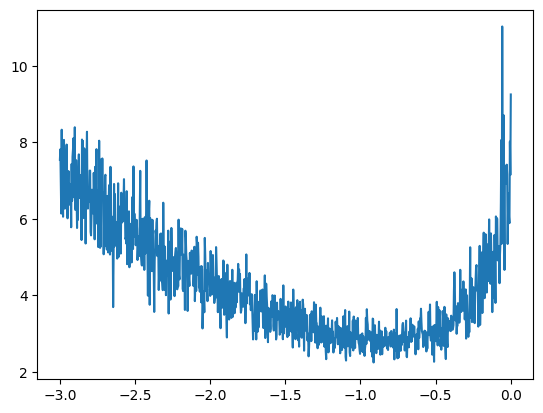

In [77]:
# plt.plot(lri, lossi)

In [86]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.3951313495635986


Now closer to how we actually build and test models

In [ ]:
#   training split, dev/validation split, test split
#  80% of the data, 10% of the data, 10% of the data
# training split is used to train the model
# dev split is used to tune the hyperparameters
# test split is used to evaluate the model

In [130]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [131]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [132]:
# now made respectable
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [133]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [134]:
for p in parameters:
  p.requires_grad = True

In [135]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [136]:
lri = []
lossi = []
stepi = []

In [145]:
for i in range(50000):
    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # Forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])


    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data -= p.grad.data * lr
    
    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.339381456375122


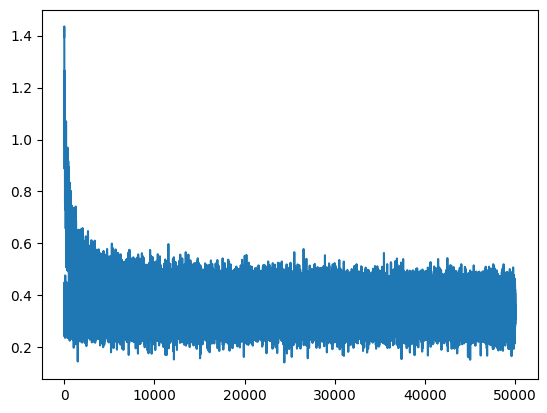

In [142]:
plt.plot(stepi, lossi)

In [146]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.170879364013672


In [147]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.194812536239624


In [148]:
# sample from the model
g = torch.Generator().manual_seed(2147483647) # for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size 
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out[:-1]))


junide
janasia
prefaria
nai
jirrito
sabrayeem
samelauria
levian
deyainr
imel
seja
evy
arth
fariumerif
demmy
prits
wah
jaylynora
yaenacely
jamira


In [ ]:
# Show embedding space
# plt.figure(figsize=(8, 8))
# plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
# plt.grid('minor')